# Beispiel 4.1

Obwohl `pymc` eine intuitive Syntax für beliebige Modelle bietet, 
kann diese für bestimmte Anwendungen dennoch unübersichtlich werden. `Bambi` fokussiert sich auf Regressionsmodelle und bietet eine eingängige Syntax, welche sich an der Statistiksoftware `R` orientiert. 

In [30]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
from scipy.interpolate import PchipInterpolator
from scipy.stats import linregress

In [31]:
import pandas as pd

werbung = pd.read_csv("./Daten/Werbung.csv").drop(["Unnamed: 0"], axis=1)

werbung.head()
print(werbung.head())

      TV  Radio  Zeitung  Verkauf
0  230.1   37.8     69.2     22.1
1   44.5   39.3     45.1     10.4
2   17.2   45.9     69.3      9.3
3  151.5   41.3     58.5     18.5
4  180.8   10.8     58.4     12.9


In [32]:
import bambi as bmb
model_t = bmb.Model("Verkauf ~ TV", werbung)
idata_t = model_t.fit(random_seed=123)
model_t

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TV]


/opt/conda/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


       Formula: Verkauf ~ TV
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 14.0225, sigma: 25.8525)
            TV ~ Normal(mu: 0.0, sigma: 0.1519)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 5.2044)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

- Auf der linken Seite des Tilde Symbols ($\sim$) steht die Zielvariable, auf der rechten Seite die Prädiktorvariable.
- Standardmässig geht `Bambi` davon aus, dass die Likelihood-Funktion eine Normalverteilung ist. Dies kann mit Hilfe des Arguments `family` geändert werden. 
- Die Syntax erlaubt es nicht, Prior-Verteilungen zu spezifizieren, sondern bloss wie die Zielvariable mit der Prädiktorvariable zusammenhängt.

Das Modell kann graphisch visualisiert werden, siehe folgende  Abbildung, und zwar mit Hilfe des folgenden Codes:

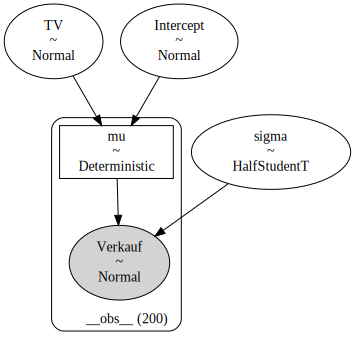

In [22]:
model_t.graph(name="./bambi_linear_werbung_dag")

Mit `az.summary()` erhalten wir alle relevanten Information aus dem gefitteten Modell. 

In [33]:
az.summary(idata_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,7.033,0.469,6.176,7.944,0.006,0.004,5886.0,3153.0,1.0
TV,0.048,0.003,0.043,0.053,0.000,0.000,6668.0,3114.0,1.0
sigma,3.277,0.164,2.968,3.580,0.002,0.001,6184.0,3096.0,1.0


Die standardmässigen Prior-Verteilungen können überschrieben werden, indem ein dictionary dem `priors` Argument im `bmb.Model` übergeben wird:

In [7]:
priors = {"TV": bmb.Prior("HalfNormal", sigma=3),
          "sigma": bmb.Prior("Gamma",  mu=1, sigma=2),
          }
a_model_wcp = bmb.Model("Verkauf ~ TV", werbung, priors=priors)
a_model_wcp

       Formula: Verkauf ~ TV
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 14.0225, sigma: 13.011)
            TV ~ HalfNormal(sigma: 3.0)
        
        Auxiliary parameters
            sigma ~ Gamma(mu: 1.0, sigma: 2.0)

Möchte man den $y$-Achsenabschnitt vom Modell entfernen, so kann dies wie folgt erreicht werden:

In [9]:
no_intercept_model = bmb.Model("Verkauf ~ 0 + TV", werbung)
no_intercept_model

       Formula: Verkauf ~ 0 + TV
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            TV ~ Normal(mu: 0.0, sigma: 0.1519)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 5.2044)

Nun wollen wir die Unsicherheiten für den Erwartungswert der verkauften Produkteinheiten `Verkauf` und für die Vorhersage der der verkauften Produkteinheiten `Verkauf` darstellen. 

`Bambi` hat ein Submodul `interpret`, dessen Funktion `plot_predictions` den Posterior Mean mit dem 94\% HDI und die Posterior Predictive Verteilung aufzeichnet.

/opt/conda/lib/python3.10/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: TV
/opt/conda/lib/python3.10/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: TV


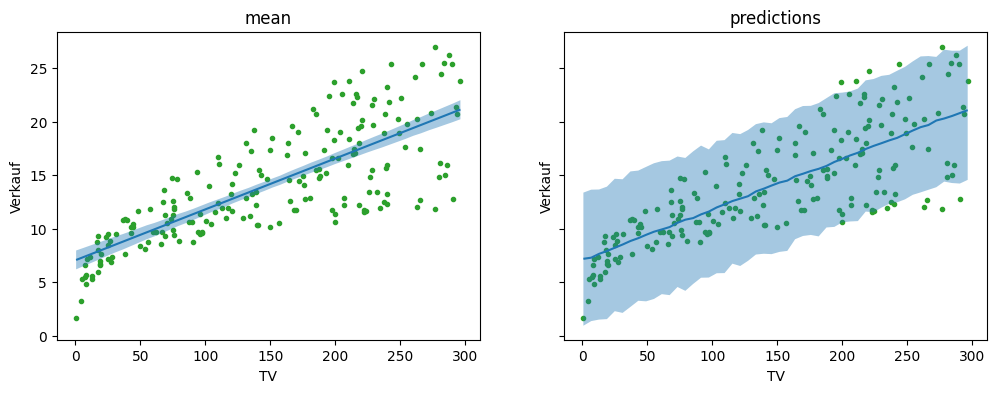

In [13]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4)) 
bmb.interpret.plot_predictions(model_t, idata_t, "TV", ax=axes[0])
bmb.interpret.plot_predictions(model_t, idata_t, "TV", pps=True, ax=axes[1])
axes[0].plot(werbung.TV, werbung.Verkauf, "C2.", zorder=-3)
axes[1].plot(werbung.TV, werbung.Verkauf, "C2.", zorder=-3)
axes[0].set_title("mean")
axes[1].set_title("predictions");
plt.savefig("./bambi_linear_werbung_mean_pss.png")

Die Unsicherheit für die vorhergesagten Verkäufe von Produkteinheiten ist viel grösser als die Unsicherheit für den Mittelwert. Dies ist der Fall, da die Posterior Predictive Verteilung sowohl die Unsicherheit in den Modellparametern wie die Unsicherheit in den Daten berücksichtigt, während die Posterior Verteilung für den Mittelwert bloss die Unsicherheit für die $y$-Achsenabschnitt- und Steigungsparametern berücksichtigt.